In [71]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import keras
import import_ipynb
import random 
import math
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from tensorflow.keras.applications import VGG16
from sklearn.decomposition import PCA


# 1. Configuration des chemins et paramètres
test_dir = r"C:\Insa\cours4a\projetmulti\test_images\donnees2\test"
train_dir =  r"C:\Insa\cours4a\projetmulti\test_images\donnees2\train"
og_dir = r"C:\Insa\cours4a\projetmulti\test_images\donnees2\originales"


size_image_x=240
size_image_y=240
input_shape = (size_image_x, size_image_y, 1)

In [72]:
########################
###### Chargement des données ######
resize_width, resize_height = 480, 256

def cropped_image(img_path):
    """Charge une image, détecte un cercle, recadre autour (et la convertit en niveaux de gris.)"""
    # Charger l'image
    image0 = cv2.imread(img_path)
    
    if image0 is None:
        print(f"Erreur : Impossible de charger {img_path}")
        return None  # Retourner None au lieu de 'continue'
    
    # Redimensionner l'image à 480x256 pour la détection du cercle
    image = cv2.resize(image0, (resize_width, resize_height))
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Détecter les cercles avec HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300, param1=100, param2=10, minRadius=100, maxRadius=200)

    # Dimensions de l'image redimensionnée
    height, width = gray.shape
    center_x, center_y = width // 2, height // 2

    # Sélectionner le cercle le plus proche du centre, mais uniquement s'il est entièrement visible
    best_circle = None
    min_distance = float("inf")

    if circles is not None:
        for circle in circles[0, :]:
            x, y, r = circle

            # Vérifier que le cercle est entièrement contenu dans l'image
            if (x - r >= 0 and y - r >= 0 and x + r <= width and y + r <= height):
                distance_to_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if distance_to_center < min_distance:
                    min_distance = distance_to_center
                    best_circle = circle
    # Si un cercle a été détecté et validé
    if best_circle is not None:
        x, y, r = best_circle  # Coordonnées du cercle sur l'image redimensionnée

        # Mise à l'échelle des coordonnées et du rayon
        scale_x = image0.shape[1] / resize_width
        scale_y = image0.shape[0] / resize_height
        x = int(x * scale_x)
        y = int(y * scale_y)
        r = int(r * min(scale_x, scale_y))  # Adapter le rayon

        # Définir la taille du carré basé sur le diamètre
        side = 2 * r  

        # Calculer les nouvelles coordonnées pour assurer un carré
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r

        # Vérifier que les coordonnées restent dans les limites de l'image
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image0.shape[1], x2), min(image0.shape[0], y2)

        # Recadrer l'image sur l'image originale
        cropped_image = image0[y1:y2, x1:x2]

        # Convertir en noir et blanc
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return cropped_gray  # Retourner l'image recadrée et en niveaux de gris
    else : 
        print(f"Aucun cercle trouvé pour: {img_path}")
        return None
        
# Fonction pour charger les images locales
def load_local_images(dataset_path, image_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))  # Liste des classes

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cropped_image(img_path)
            if img is None:
                continue  # Sauter l'image si échec du crop

            try:
                img_resized = Image.fromarray(img).resize(image_size)
                img_array = img_to_array(img_resized) / 255.0
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Erreur lors du traitement de {img_path}: {e}")

    return np.array(images), np.array(labels)

def create_pairs(images, labels):
    imagePairs = []
    labelPairs = []

    num_classes = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(num_classes)]

    for ind in range(len(images)):
        currImage = images[ind]
        label = labels[ind]

        for i in range(1):
            # Trouver une autre image de la même classe
            indB = np.random.choice(idx[label])
            posImage = images[indB]
            imagePairs.append([currImage, posImage])
            labelPairs.append(1)  # Même classe -> 1
    
            # Trouver une image d'une autre classe
            neg_idx = np.where(labels != label)[0]
            negImage = images[np.random.choice(neg_idx)]
            imagePairs.append([currImage, negImage])
            labelPairs.append(0)  # Classe différente -> 0

    return np.array(imagePairs, dtype=np.float32), np.array(labelPairs, dtype=np.int32)

image_size=(size_image_x, size_image_y)
x_test, y_test = load_local_images(train_dir, image_size)
#x_test = np.expand_dims(x_test, axis=-1)
pairs, labels_pairs = create_pairs(x_test, y_test)
print(f"Nombre total de paires générées : {len(pairs)}")

Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (50).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (53).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (62).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (63).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (76).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe1\modifiee_classe1 (83).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe2\modifiee_classse2 (49).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\train\classe2\modifiee_classse2 (53).jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\tra

Model: "siamese"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)          │ (None, 240, 240, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 240, 240, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 240, 240, 8)         │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 120, 120, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 120, 120, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 120, 120, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 120, 120, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 60, 60, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 60, 60, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 50)                  │             850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 50)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,194 (8.57 KB)

 Trainable params: 2,146 (8.38 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - accuracy: 0.4637 - loss: 2.3580 - val_accuracy: 0.6875 - val_loss: 0.6892
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5036 - loss: 1.7429 - val_accuracy: 0.5375 - val_loss: 0.6885
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.4424 - loss: 1.4310 - val_accuracy: 0.6500 - val_loss: 0.6797
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.4741 - loss: 1.0069 - val_accuracy: 0.6875 - val_loss: 0.6757
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.4950 - loss: 0.8208 - val_accuracy: 0.7000 - val_loss: 0.6726
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.4889 - loss: 0.7607 - val_accuracy: 0.6250 - val_loss: 0.6638
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.4562 - loss: 0.7425 - val_accuracy: 0.6250 - val_loss: 0.6545
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.5107 - loss: 0.7051 - val_accuracy:

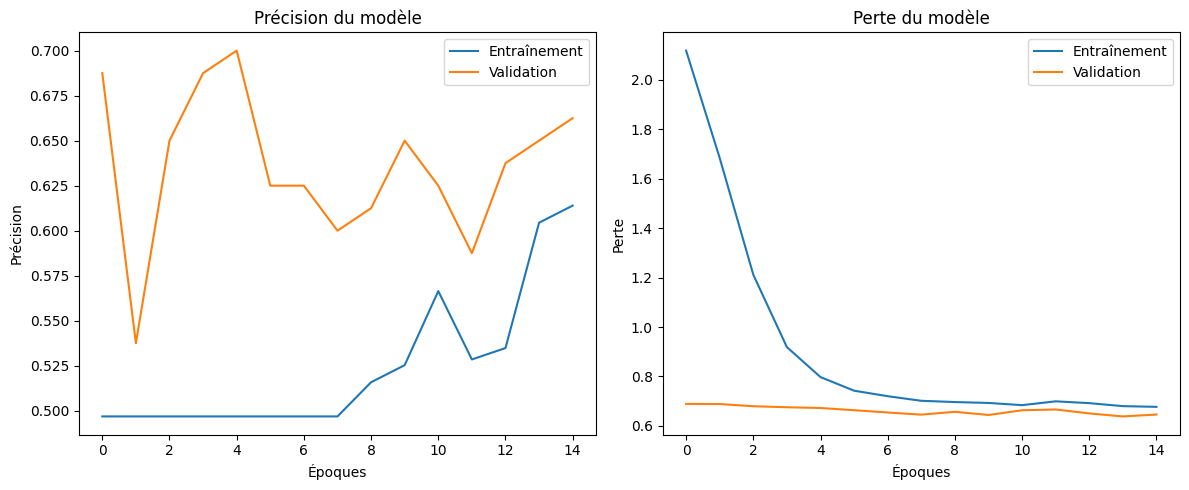

In [73]:
########################
###### Modèle Siamois ######
# 4. Création du modèle Siamese
input_shape = (size_image_y, size_image_x, 1)

import tensorflow.keras.backend as K
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_siamese_model(input_shape):
    """Crée et retourne le modèle Siamese."""
    
    input_img = Input(shape=input_shape)
    
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    """
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
"""
    output = keras.layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
    #output = layers.Flatten()(output)
    output = keras.layers.Dense(50, activation="sigmoid")(output)
    """
    
    x = layers.Flatten()(x)
    #x = layers.Dense(64, activation='relu')(x)  # Réduction de la taille du vecteur
    x = layers.Dense(128, activation='relu')(x)  # Augmente légèrement la complexité
    """
    output = layers.Dropout(0.3)(output)
    
    siamese = Model(input_img, output, name="siamese")
    siamese.summary()
    
    input_img_1 = Input(shape=input_shape)
    input_img_2 = Input(shape=input_shape)

    encoded_1 = siamese(input_img_1)

    encoded_2 = siamese(input_img_2)

    #distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded_1, encoded_2])
    distance = layers.Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))([encoded_1, encoded_2])
    output = layers.Dense(1, activation='sigmoid')(distance)

    siamese_model = Model(inputs=[input_img_1, input_img_2], outputs=output)
    return siamese_model

siamese_model = create_siamese_model(input_shape)

# 6. Compilation et callbacks
#siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=contrastive_loss, metrics=['accuracy'])
#siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Séparer les paires en deux entrées distinctes
X1 = pairs[:, 0]  # Première image de la paire
X2 = pairs[:, 1]  # Deuxième image de la paire
y = labels_pairs   # Labels (1 si similaires, 0 sinon)

# Création des indices pour les paires
indices = np.arange(len(X1))  # Liste d'indices correspondant aux paires

# Division des indices pour garder les paires intactes
indices_train, indices_val = train_test_split(indices, test_size=0.2, random_state=42)

# Application de la division des indices à X1, X2, et y
X1_train, X2_train, y_train = X1[indices_train], X2[indices_train], y[indices_train]
X1_val, X2_val, y_val = X1[indices_val], X2[indices_val], y[indices_val]

# Redimensionner les images comme avant
X1_train = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X1_train], dtype=np.float32)
X2_train = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X2_train], dtype=np.float32)

X1_val = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X1_val], dtype=np.float32)
X2_val = np.array([cv2.resize(x, (size_image_x, size_image_y)) for x in X2_val], dtype=np.float32)

# Reshaper les labels
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Vérification de la cohérence des paires
assert len(X1_train) == len(X2_train) == len(y_train)
assert len(X1_val) == len(X2_val) == len(y_val)

def convert_to_gray(images):
    gray_images = []
    for img in images:
        if img is None:
            raise ValueError("Erreur : Une image n'a pas été chargée correctement.")

        # Vérifier si l'image est déjà en grayscale
        if len(img.shape) == 2:  # Image au format (H, W)
            img = np.expand_dims(img, axis=-1)  # Ajouter une dimension (H, W, 1)
        elif img.shape[-1] == 3:  # Image au format (H, W, 3) (RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convertir en grayscale
            img = np.expand_dims(img, axis=-1)  # Ajouter une dimension (H, W, 1)

        gray_images.append(img)

    return np.array(gray_images)

# Appliquer la conversion sur les ensembles d'entraînement et de validation
X1_train = convert_to_gray(X1_train)
X2_train = convert_to_gray(X2_train)
X1_val = convert_to_gray(X1_val)
X2_val = convert_to_gray(X2_val)

# Entraîner le modèle siamois
history = siamese_model.fit([X1_train, X2_train], y_train, 
                  validation_data=([X1_val, X2_val], y_val), 
                  epochs=15, 
                  batch_size=8, 
                  #callbacks=[early_stopping, reduce_lr]  # Ajout du callback ReduceLROnPlateau
)
# Affichage des courbes
plt.figure(figsize=(12, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
🔹 Visualisation paire SIMILAIRE la plus similaire (Label = 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


C:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


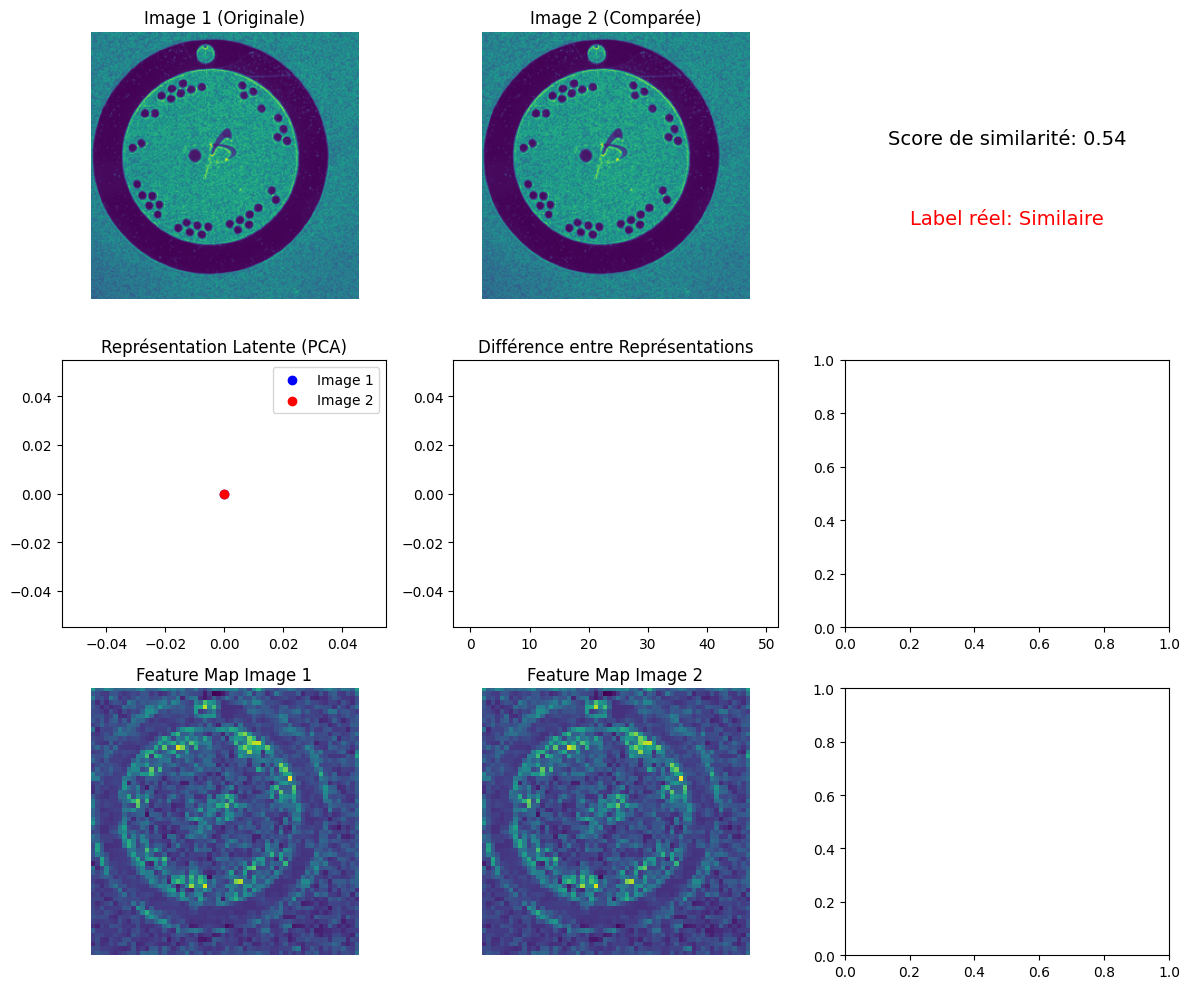

🔹 Visualisation paire SIMILAIRE la moins similaire (Label = 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


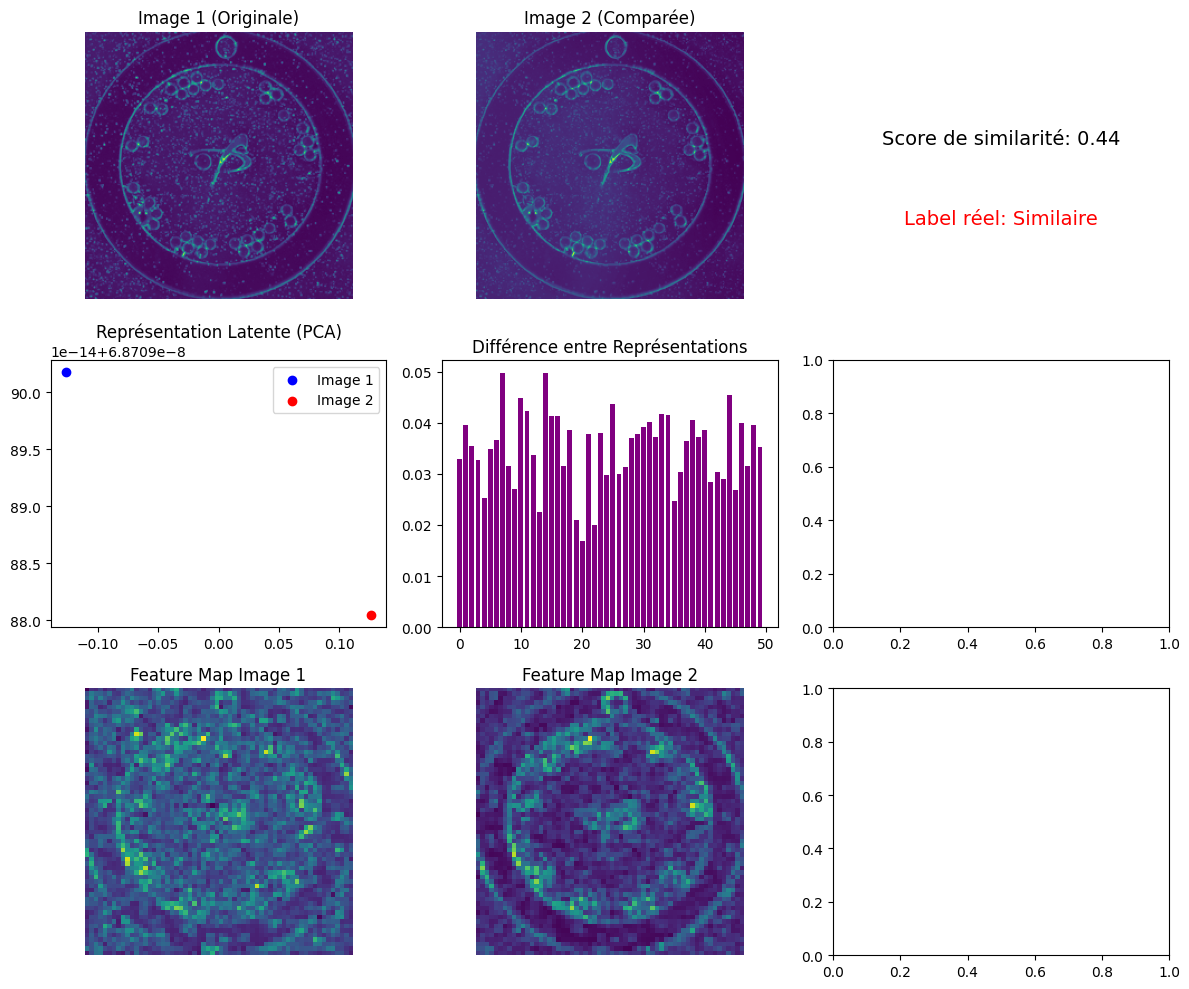

🔹 Visualisation paire DIFFÉRENTE la plus similaire (Label = 0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


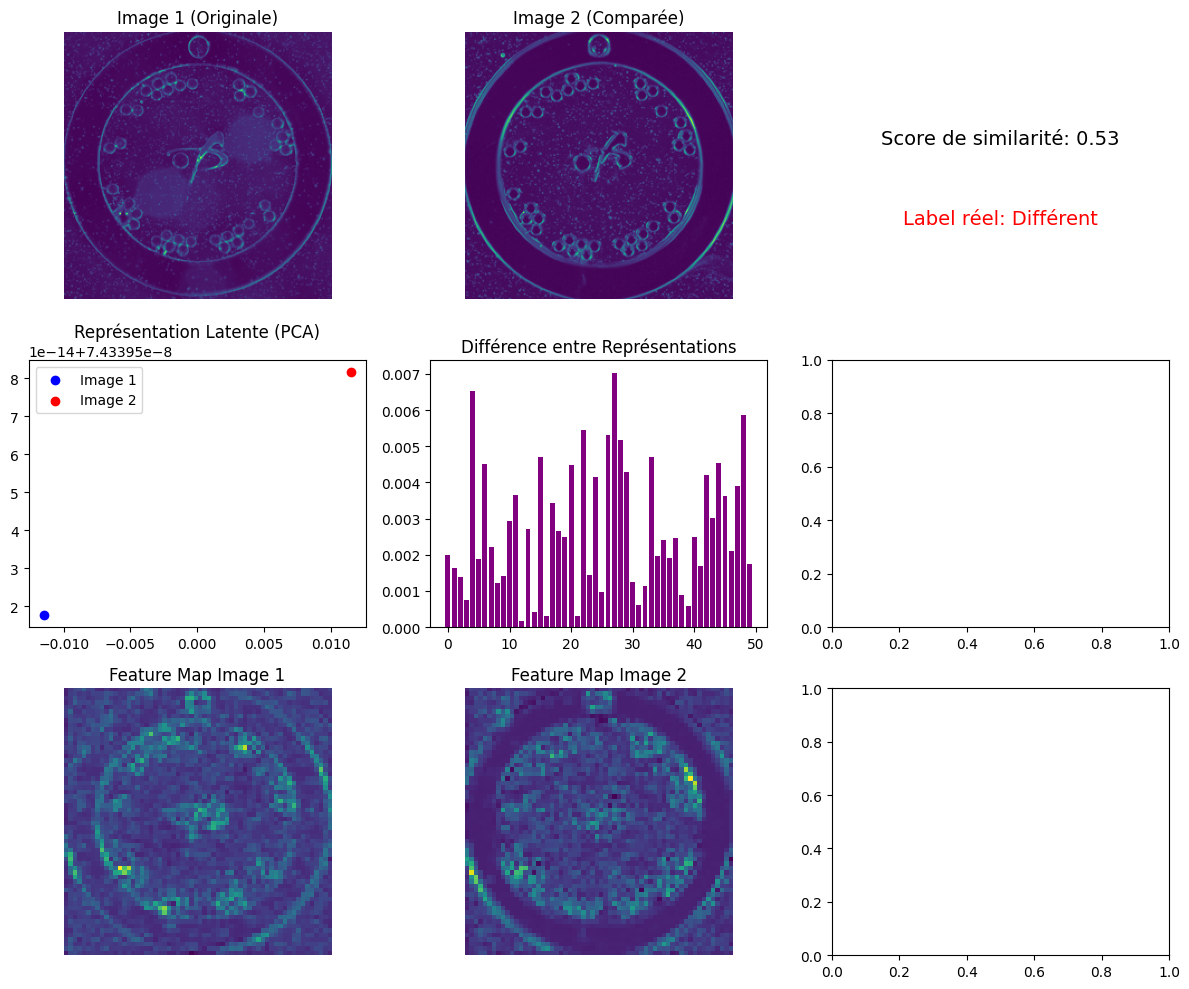

🔹 Visualisation paire DIFFÉRENTE la moins similaire (Label = 0)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


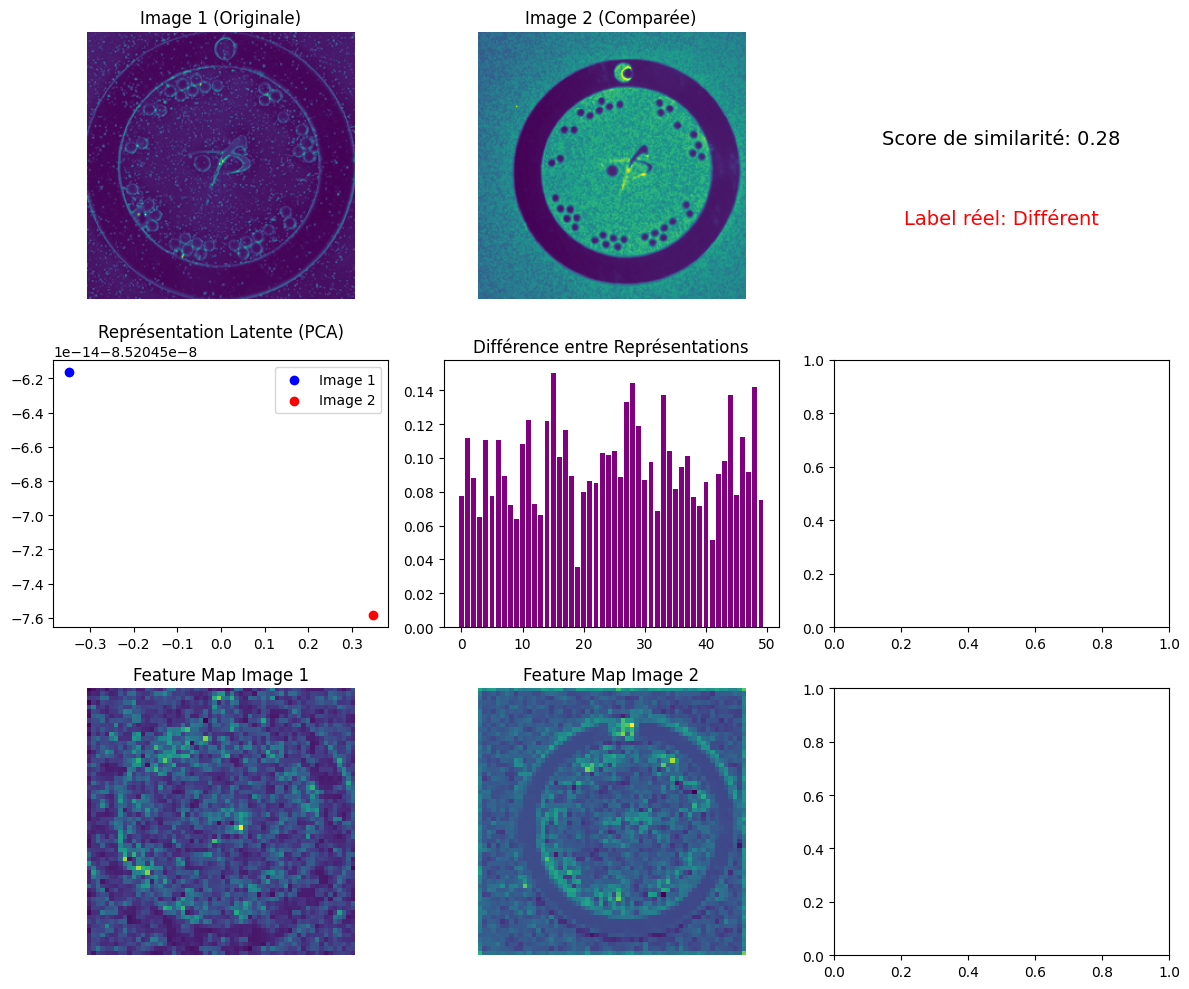

In [63]:
##################################
### test amélioration -> voir avant couche dense
def visualiser_paire(idx, label):
    """Affiche la comparaison pour une paire donnée (idx) dans le jeu de validation."""
    
    image1 = np.expand_dims(X1_val[idx], axis=0)  # Ajouter batch dim
    image2 = np.expand_dims(X2_val[idx], axis=0)

    # Récupérer l'encodeur Siamese
    encoder_siamois = siamese_model.get_layer("siamese")  

    # 🔹 EXTRACTION DES REPRESENTATIONS LATENTES (Dense)
    latent1 = encoder_siamois.predict(image1)  
    latent2 = encoder_siamois.predict(image2)  

    # 🔹 Trouver la dernière couche 2D avant GlobalAveragePooling2D
    last_conv_layer = None
    for layer in reversed(encoder_siamois.layers):
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.MaxPooling2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("Aucune couche 2D trouvée avant GlobalAveragePooling2D ! Vérifiez l'architecture.")

    model_intermediaire = Model(inputs=encoder_siamois.input, outputs=last_conv_layer.output)
    
    feature_map1 = model_intermediaire.predict(image1)  # Features avant Dense (Image 1)
    feature_map2 = model_intermediaire.predict(image2)  # Features avant Dense (Image 2)

    # 🔹 Normalisation des images pour imshow ([0,255] → [0,1])
    image1_display = np.clip(X1_val[idx] / 255.0, 0, 1)
    image2_display = np.clip(X2_val[idx] / 255.0, 0, 1)

    # Création de la figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    # 🔹 Affichage des images d'origine
    axes[0, 0].imshow(image1_display)
    axes[0, 0].axis("off")
    axes[0, 0].set_title("Image 1 (Originale)")

    axes[0, 1].imshow(image2_display)
    axes[0, 1].axis("off")
    axes[0, 1].set_title("Image 2 (Comparée)")

    # 🔹 Vérification de la variance avant PCA
    if latent1.shape[1] > 2:
        if np.var(latent1) > 0 and np.var(latent2) > 0:
            pca = PCA(n_components=2)
            latent_pca = pca.fit_transform(np.vstack([latent1, latent2]))

            axes[1, 0].scatter(latent_pca[0, 0], latent_pca[0, 1], c="blue", label="Image 1")
            axes[1, 0].scatter(latent_pca[1, 0], latent_pca[1, 1], c="red", label="Image 2")
            axes[1, 0].legend()
            axes[1, 0].set_title("Représentation Latente (PCA)")
        else:
            axes[1, 0].text(0.5, 0.5, "Variance nulle (PCA impossible)", ha="center", va="center")
            axes[1, 0].axis("off")
    else:
        axes[1, 0].plot(latent1.flatten(), label="Image 1", color="blue")
        axes[1, 0].plot(latent2.flatten(), label="Image 2", color="red")
        axes[1, 0].legend()
        axes[1, 0].set_title("Représentation Latente (Vecteur)")

    # 🔹 Affichage de la différence absolue entre les représentations
    difference = np.abs(latent1 - latent2)
    axes[1, 1].bar(range(len(difference.flatten())), difference.flatten(), color="purple")
    axes[1, 1].set_title("Différence entre Représentations")

    # 🔹 Affichage de la dernière couche 2D avant la Dense (Feature Maps)
    mean_feature1 = np.mean(feature_map1[0], axis=-1)  # Moyenne des cartes de caractéristiques
    mean_feature2 = np.mean(feature_map2[0], axis=-1)

    axes[2, 0].imshow(mean_feature1, cmap="viridis")
    axes[2, 0].set_title("Feature Map Image 1")
    axes[2, 0].axis("off")

    axes[2, 1].imshow(mean_feature2, cmap="viridis")
    axes[2, 1].set_title("Feature Map Image 2")
    axes[2, 1].axis("off")

    # 🔹 Calcul et affichage de la similarité (sortie du modèle Siamese)
    similarity_score = siamese_model.predict([image1, image2])[0, 0]
    label_str = "Similaire" if label == 1 else "Différent"
    
    axes[0, 2].text(0.5, 0.6, f"Score de similarité: {similarity_score:.2f}", fontsize=14, ha="center", va="center")
    axes[0, 2].text(0.5, 0.3, f"Label réel: {label_str}", fontsize=14, color="red", ha="center", va="center")
    axes[0, 2].axis("off")

    plt.tight_layout()
    plt.show()
    
    
similarity_scores = siamese_model.predict([X1_val, X2_val]).flatten()

# Paires similaires (label = 1)
similar_indices = np.where(y_val == 1)[0]
similar_scores = similarity_scores[similar_indices]
idx_similaire_max_similaires = similar_indices[np.argmax(similar_scores)]
print("🔹 Visualisation paire SIMILAIRE la plus similaire (Label = 1)")
visualiser_paire(idx_similaire_max_similaires, 1)
idx_similaire_min_similaires = similar_indices[np.argmin(similar_scores)]
print("🔹 Visualisation paire SIMILAIRE la moins similaire (Label = 1)")
visualiser_paire(idx_similaire_min_similaires, 1)

# Paires différentes (label = 0)
different_indices = np.where(y_val == 0)[0]
different_scores = similarity_scores[different_indices]
idx_different_max_differents = different_indices[np.argmax(different_scores)]   
print("🔹 Visualisation paire DIFFÉRENTE la plus similaire (Label = 0)")
visualiser_paire(idx_different_max_differents, 0)
idx_different_min_differents = different_indices[np.argmin(different_scores)]   
print("🔹 Visualisation paire DIFFÉRENTE la moins similaire (Label = 0)")
visualiser_paire(idx_different_min_differents, 0)

Fichiers dans le dossier : ['classe1', 'classe2', 'classe3', 'classe4', 'classe5']
5 images originales chargées.
Fichiers chargés : ['C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe1\\originale.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe2\\Extime643.9ms-gain3.2x-5X- red267_4807.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe3\\Extime643.9ms-gain3.2x-5X- red267_4779.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe4\\Extime643.9ms-gain3.2x-5X- red2.67 bleu2.47_4849.jpg', 'C:\\Insa\\cours4a\\projetmulti\\test_images\\donnees2\\originales\\classe5\\8s-gain 1x-5X-red2.43-bleu10contrast 1_5297.jpg']
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\test2\Chien.jpg
Aucun cercle trouvé pour: C:\Insa\cours4a\projetmulti\test_images\donnees2\test2\test29.JPG
Test modèle siamois chargé !


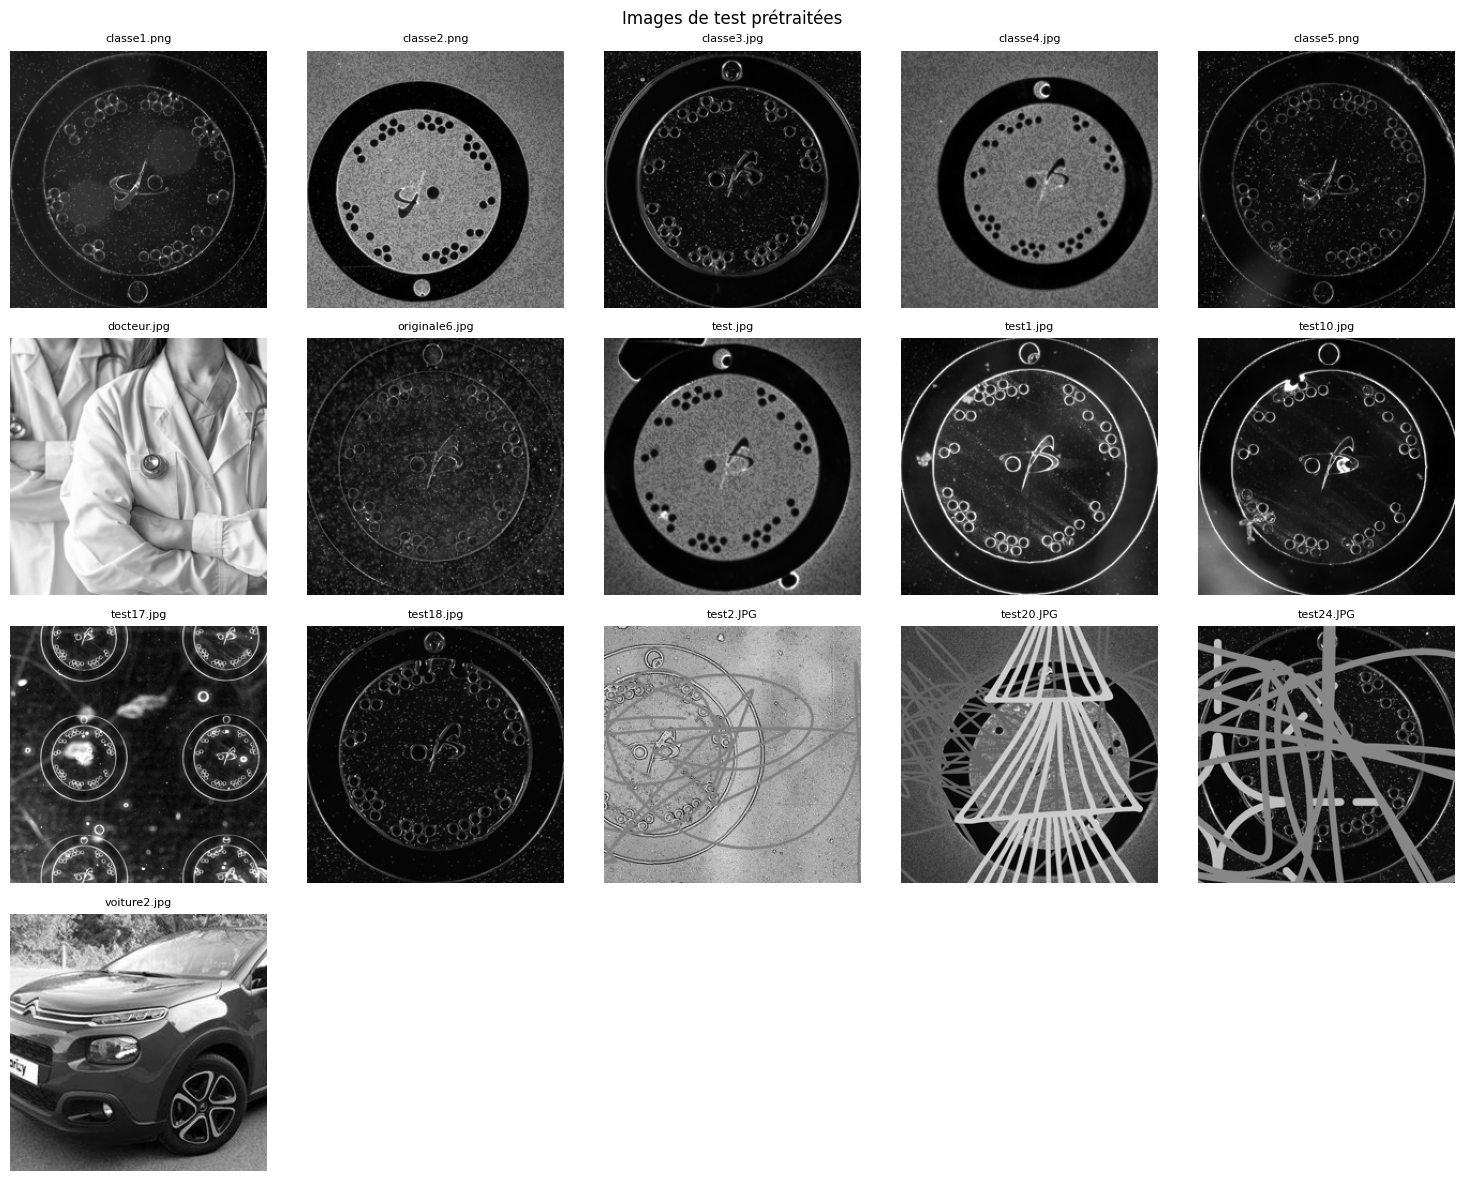

In [70]:
################################
####### Chargement données de test ######

# Dimensions pour le redimensionnement
resize_width, resize_height = 480, 256

def cropped_and_gray_image(img_path):
    """Charge une image, détecte un cercle, recadre autour et la convertit en niveaux de gris."""
    # Charger l'image
    image0 = cv2.imread(img_path)

    if image0 is None:
        print(f"Erreur : Impossible de charger {img_path}")
        return None  # Retourner None au lieu de 'continue'

    # Redimensionner l'image à 480x256 pour la détection du cercle
    image = cv2.resize(image0, (resize_width, resize_height))

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Détecter les cercles avec HoughCircles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=300, param1=100, param2=10, minRadius=100, maxRadius=200)

    # Dimensions de l'image redimensionnée
    height, width = gray.shape
    center_x, center_y = width // 2, height // 2

    # Sélectionner le cercle le plus proche du centre, mais uniquement s'il est entièrement visible
    best_circle = None
    min_distance = float("inf")

    if circles is not None:
        for circle in circles[0, :]:
            x, y, r = circle

            # Vérifier que le cercle est entièrement contenu dans l'image
            if (x - r >= 0 and y - r >= 0 and x + r <= width and y + r <= height):
                distance_to_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                if distance_to_center < min_distance:
                    min_distance = distance_to_center
                    best_circle = circle
    
    # Si un cercle a été détecté et validé
    if best_circle is not None:
        x, y, r = best_circle  # Coordonnées du cercle sur l'image redimensionnée

        # Mise à l'échelle des coordonnées et du rayon
        scale_x = image0.shape[1] / resize_width
        scale_y = image0.shape[0] / resize_height
        x = int(x * scale_x)
        y = int(y * scale_y)
        r = int(r * min(scale_x, scale_y))  # Adapter le rayon

        # Définir la taille du carré basé sur le diamètre
        side = 2 * r  

        # Calculer les nouvelles coordonnées pour assurer un carré
        x1, y1 = x - r, y - r
        x2, y2 = x + r, y + r

        # Vérifier que les coordonnées restent dans les limites de l'image
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image0.shape[1], x2), min(image0.shape[0], y2)

        # Recadrer l'image sur l'image originale
        cropped_image = image0[y1:y2, x1:x2]

        # Convertir en noir et blanc
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return cropped_gray  # Retourner l'image recadrée et en niveaux de gris
    else : 
        print(f"Aucun cercle trouvé pour: {img_path}")
        return None

def load_and_preprocess_test_images(load_dir, size_image_x, size_image_y):
    """Charge, recadre et prétraite les images de test en niveaux de gris"""
    test_images = []
    valid_file_names = []  # Liste pour stocker les fichiers valides
    test_image_files = [f for f in os.listdir(load_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in test_image_files:
        img_path = os.path.join(load_dir, file)
        try:
            img = cropped_and_gray_image(img_path)  # Récupérer l'image recadrée
            
            if img is not None:  # Si le recadrage a réussi
                img_resized = Image.fromarray(img).resize((size_image_x, size_image_y))
                img_array = np.array(img_resized) / 255.0  # Normalisation [0,1]
                test_images.append(img_array)
                valid_file_names.append(file)  # Ajouter uniquement si l'image est valide
            
        except Exception as e:
            print(f"❌ Erreur avec l'image {file}: {e}")

    if len(test_images) == 0:
        raise ValueError("❌ Aucune image de test chargée. Vérifiez le dossier des images de test.")

    return np.array(test_images), valid_file_names  # Retourne les noms filtrés


def load_and_preprocess_original_images(base_dir, size_image_x, size_image_y):
    """Charge toutes les images des sous-dossiers de base_dir et les prétraite."""
    images = []  # Liste pour stocker les images
    image_files = []  # Liste pour stocker les noms de fichiers
    base_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    # Explorer chaque sous-dossier (classe)
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)

        # Vérifier que c'est bien un dossier avant de le parcourir
        if os.path.isdir(class_path):  
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)

                # Vérifier si c'est une image
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        # Charger l'image en niveaux de gris
                        img = Image.open(file_path).convert("L")  # "L" = grayscale
                        img_resized = img.resize((size_image_x, size_image_y))  # Redimensionner
                        img_array = np.array(img_resized) / 255.0  # Normalisation [0,1]

                        images.append(img_array)  # Ajouter à la liste
                        image_files.append(file_path)  # Stocker le chemin du fichier
                        
                    except Exception as e:
                        print(f"❌ Erreur avec l'image {file_name}: {e}")

    # Vérifier que des images ont bien été chargées
    if len(images) == 0:
        raise ValueError("Aucune image originale chargée. Vérifiez le dossier des images originales.")

    return np.array(images), image_files  # Conversion en numpy array après remplissage


# Afficher la liste des fichiers dans og_dir
print("Fichiers dans le dossier :", os.listdir(og_dir))

# Chargement des images
base_array, base_files = load_and_preprocess_original_images(og_dir, size_image_x, size_image_y)

print(f"{len(base_array)} images originales chargées.")
print("Fichiers chargés :", base_files)

# 9. Évaluation sur les images de test
test_images, test_image_files = load_and_preprocess_test_images(test_dir, size_image_x, size_image_y)
print("Test modèle siamois chargé !")

def show_images(images, file_names, title, cols=5):
    num_images = len(images)
    rows = math.ceil(num_images / cols)  # Calcul du nombre de lignes

    plt.figure(figsize=(cols * 3, rows * 3))  # Taille ajustée
    
    for i, (image, file_name) in enumerate(zip(images, file_names)):  
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap="gray")  # Affichage en niveaux de gris
        plt.title(file_name, fontsize=8)  # Associer image et fichier
        plt.axis("off")

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
# Afficher les images de test avec une grille plus lisible
show_images(test_images, test_image_files, "Images de test prétraitées")

In [25]:
####### Similarités modèles siamois (Conparaison image par image) ######
name = []
for filename in os.listdir(test_dir):
    name.append(filename)
def comparer_images(image1, image2):
    """Compare deux images avec le modèle siamois et retourne un score de similarité."""
    # Assurez-vous que l'image est bien un tableau NumPy avec la bonne forme
    image1 = np.expand_dims(image1, axis=0)  # (1, hauteur, largeur, canaux)
    image2 = np.expand_dims(image2, axis=0)  

    # Vérification des dimensions avant d'envoyer au modèle
    #print(f"✅ Forme image1 : {image1.shape}, image2 : {image2.shape}")

    # Passage dans le modèle
    try:
        prediction = siamese_model.predict([image1, image2])
        similarity_score = float(np.mean(prediction))
        return similarity_score
    except Exception as e:
        print(f"❌ Erreur dans la prédiction : {e}")
        return 0.0  # Retourner un score bas en cas d'erreur

# Parcours des images test
for file in test_image_files:
    img_path = os.path.join(test_dir, file)
    try:
        # Charger l'image en niveaux de gris
        image_test = Image.open(img_path).convert("L")  # Convertir en niveaux de gris
        image_test = image_test.resize((size_image_x, size_image_y))  # Redimensionner
        img_array = np.array(image_test, dtype=np.float32) / 255.0  # Normalisation
        
        # Ajouter une dimension de canal pour compatibilité modèle (hauteur, largeur, 1)
        img_array = np.expand_dims(img_array, axis=-1)  

        # Comparer avec chaque image originale
        for i, img_orig in enumerate(base_array):
            img_orig_exp = np.expand_dims(img_orig, axis=-1)  # S'assurer du bon format
            similarity = comparer_images(img_orig_exp, img_array)

            # Déterminer si la correspondance est vraie ou fausse
            statut = "Vrai" if similarity > 0.6 else "Faux"
            print(f"{file}: Similarité avec og {i+1} = {similarity:.4f} - {statut}")

    except Exception as e:
        print(f"❌ Erreur lors du chargement de l'image {file}: {e}")

# Sauvegarde du modèle
siamese_model.save("siamese_model.keras")
print("✅ Modèle sauvegardé.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
chien2.jpg: Similarité avec og 1 = 0.5090 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
chien2.jpg: Similarité avec og 2 = 0.5079 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
chien2.jpg: Similarité avec og 3 = 0.5025 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
chien2.jpg: Similarité avec og 4 = 0.5090 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
chien2.jpg: Similarité avec og 5 = 0.5020 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
chien2.jpg: Similarité avec og 6 = 0.5096 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
chien2.jpg: Similarité avec og 7 = 0.5098 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
chien2.jpg: Similarité avec og 8 = 0.5041 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
chien2.jpg: Similarité avec og 9 = 0.5018 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
chien2.jpg: Similarité avec og 10 = 0.5023 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
classe1 (2).jpg: Similarité avec og 1 = 0.4953 - Faux
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/st

KeyboardInterrupt: 

In [34]:
###########################
####### Similarités modèles siamois (trouver meilleure correspondance) ######
# Fonction pour calculer la meilleure correspondance avec les images de base

## déja dans la cellule d'avant mais flemme de la run
####### Similarités modèles siamois (Conparaison image par image) ######
def comparer_images(image1, image2):
    """Compare deux images avec le modèle siamois et retourne un score de similarité."""
    # Assurez-vous que l'image est bien un tableau NumPy avec la bonne forme
    image1 = np.expand_dims(image1, axis=0)  # (1, hauteur, largeur, canaux)
    image2 = np.expand_dims(image2, axis=0)  

    # Vérification des dimensions avant d'envoyer au modèle
    #print(f"✅ Forme image1 : {image1.shape}, image2 : {image2.shape}")

    # Passage dans le modèle
    try:
        prediction = siamese_model.predict([image1, image2])
        similarity_score = float(np.mean(prediction))
        return similarity_score
    except Exception as e:
        print(f"❌ Erreur dans la prédiction : {e}")
        return 0.0  # Retourner un score bas en cas d'erreur

        
def trouver_meilleure_correspondance(test_image, base_array):
    meilleure_similarite = 0
    meilleure_classe = "Inconnue"
    
    # Comparer chaque image de base avec l'image de test
    for i, img_orig in enumerate(base_array):
        img_orig = np.expand_dims(img_orig, axis=-1)  # Adapter la dimension si besoin
        
        try:
            # Calculer la similarité entre l'image de test et l'image d'origine
            similarity_score = comparer_images(img_orig, test_image)
        except Exception as e:
            print(f"❌ Erreur dans la comparaison : {e}")
            similarity_score = 0
        
        # Mise à jour de la meilleure correspondance
        if similarity_score > meilleure_similarite:
            meilleure_similarite = similarity_score
            meilleure_classe = i + 1  # Ou utiliser base_files[i] pour afficher le nom du fichier
    
    return meilleure_classe, meilleure_similarite

# Phase de test
print("\n--- Phase de Test ---")

# Boucle directement sur les images prétraitées
for img_array, filename in zip(test_images, test_image_files):
    try:
        img_array = np.expand_dims(img_array, axis=-1)  # Adapter la dimension si besoin
        
        # Trouver la meilleure correspondance
        meilleure_classe, score = trouver_meilleure_correspondance(img_array, base_array)
        print(f"✅ {filename} correspond le mieux à la classe {meilleure_classe} avec un score de {score:.4f}")

    except Exception as e:
        print(f"❌ Erreur lors du traitement de {filename} : {e}")


--- Phase de Test ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


KeyboardInterrupt: 


--- Phase de Test avec enregistrement pour graphe ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
✅ chien2.jpg → Vraie classe: 0, Prédit: 4, score: 0.4280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
✅ classe1_modifiee (1).jpg → Vraie classe: 1, Prédit: 3, score: 0.5065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
✅ classe1_modifiee (2).jpg → Vraie classe: 1, Prédit: 3, score: 0.5041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

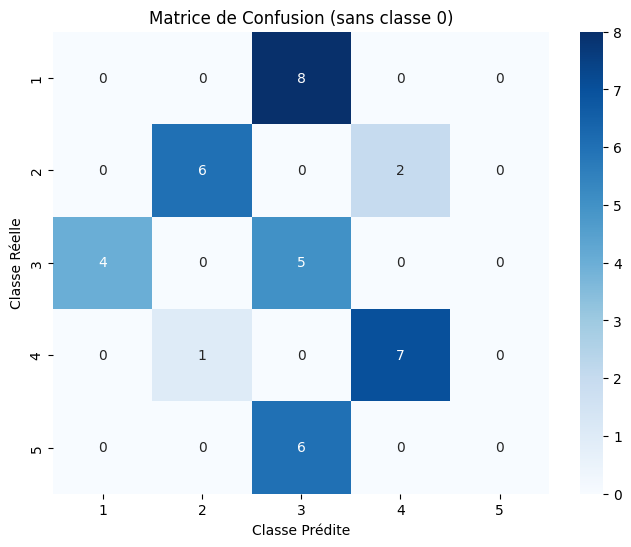

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 🔧 À adapter selon ton système de nommage de fichier ou structure de label
def extraire_classe(filename):
    # Exemple : si les noms sont "classe1_image23.png", on extrait la classe
    for i in range(1, 10):  # ou adapte selon tes vraies classes
        if f"classe{i}" in filename.lower():
            return i
    return 0  # Classe inconnue ou erreur

true_labels = []
predicted_labels = []

print("\n--- Phase de Test avec enregistrement pour graphe ---")
for img_array, filename in zip(test_images, test_image_files):
    try:
        img_array = np.expand_dims(img_array, axis=-1)

        true_class = extraire_classe(filename)
        meilleure_classe, score = trouver_meilleure_correspondance(img_array, base_array)

        true_labels.append(true_class)
        predicted_labels.append(meilleure_classe)

        print(f"✅ {filename} → Vraie classe: {true_class}, Prédit: {meilleure_classe}, score: {score:.4f}")

    except Exception as e:
        print(f"❌ Erreur pour {filename}: {e}")

# Supprimer les paires où la vraie classe ou la classe prédite est 0
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Masque : on garde seulement les classes différentes de 0
mask = (true_labels_np != 0) & (predicted_labels_np != 0)
true_labels_filtered = true_labels_np[mask]
predicted_labels_filtered = predicted_labels_np[mask]

# 🔍 Matrice de confusion
labels_unique = sorted(set(true_labels_filtered))  # Seulement les vraies classes présentes
cm = confusion_matrix(true_labels_filtered, predicted_labels_filtered, labels=labels_unique)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion (sans classe 0)")
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


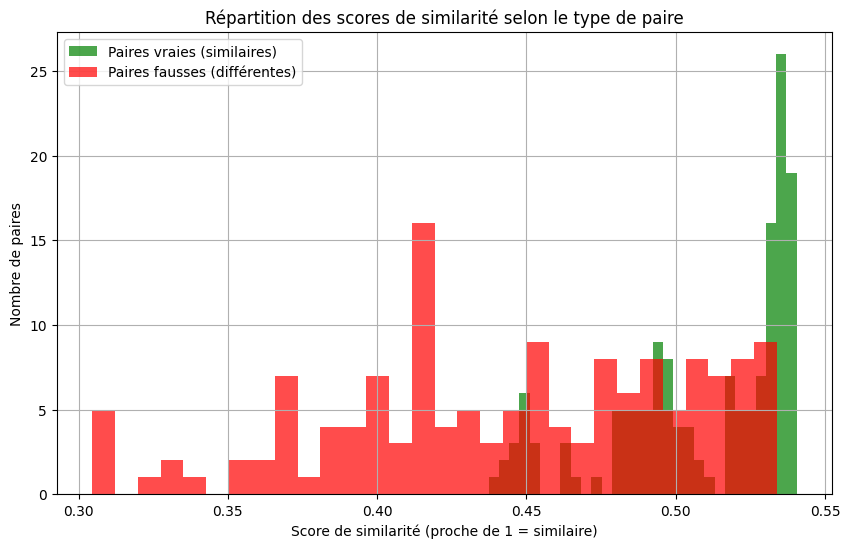

In [66]:
# ÉTAPE DE VÉRIFICATION : Histogramme des similarités

# Sélectionner un sous-ensemble de paires pour analyse (ex: 500)
num_samples = 300
sample_indices = np.random.choice(len(X1_train), size=num_samples, replace=False)

X1_sample = X1_train[sample_indices]
X2_sample = X2_train[sample_indices]
y_sample = y_train[sample_indices]

# Prédictions de similarité par le modèle
similarity_scores = siamese_model.predict([X1_sample, X2_sample])

# Extraire les scores selon le label (1 = paire vraie, 0 = paire fausse)
similarity_scores = similarity_scores.flatten()
true_pairs_scores = similarity_scores[y_sample.flatten() == 1]
false_pairs_scores = similarity_scores[y_sample.flatten() == 0]

# Affichage de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(true_pairs_scores, bins=30, alpha=0.7, label='Paires vraies (similaires)', color='green')
plt.hist(false_pairs_scores, bins=30, alpha=0.7, label='Paires fausses (différentes)', color='red')
plt.title("Répartition des scores de similarité selon le type de paire")
plt.xlabel("Score de similarité (proche de 1 = similaire)")
plt.ylabel("Nombre de paires")
plt.legend()
plt.grid(True)
plt.show()
